In [10]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

In [4]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    shape_num = len(xc)//shape_size
    xc = np.reshape(xc, (shape_num, shape_size))
    yc = np.reshape(yc, (shape_num, shape_size))
    
    for j in range(shape_num):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    p_u, p_d = 0, 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.4 >=SP[i][j]:
            p_d += 1
        if SP[i][j - 1] <= 0.4 <=SP[i][j]:
            p_u += 1
    if p_d == p_u and p_d == 3:
        
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	21
Batch 3 has 	18
Batch 4 has 	51
Batch 5 has 	15
Batch 6 has 	42
Batch 7 has 	42
Batch 8 has 	120
Batch 9 has 	15
Batch 10 has 	42
Batch 11 has 	42
Batch 12 has 	120
Batch 13 has 	39
Batch 14 has 	111
Batch 15 has 	111
Batch 16 has 	318
Batch 17 has 	15
Batch 18 has 	42
Batch 19 has 	42
Batch 20 has 	120
Batch 21 has 	39
Batch 22 has 	111
Batch 23 has 	111
Batch 24 has 	106
Batch 25 has 	39
Batch 26 has 	111
Batch 27 has 	111
Batch 28 has 	318
Batch 29 has 	105
Batch 30 has 	300
Batch 31 has 	300
Batch 32 has 	861
Batch 33 has 	15
Batch 34 has 	38
Batch 35 has 	42
Batch 36 has 	118
Batch 37 has 	39
Batch 38 has 	105
Batch 39 has 	105
Batch 40 has 	310
Batch 41 has 	37
Batch 42 has 	106
Batch 43 has 	105
Batch 44 has 	318
Batch 45 has 	101
Batch 46 has 	250
Batch 47 has 	298
Batch 48 has 	836
Batch 49 has 	36
Batch 50 has 	101
Batch 51 has 	105
Batch 52 has 	316
Batch 53 has 	105
Batch 54 has 	300
Batch 55 has 	301
Batch 56 has 	842
Batch 57 has 	103
Batch 58 has 	294
Bat

In [5]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 426 samples, validate on 107 samples
Epoch 1/1000
 - 1s - loss: 0.0181 - acc: 0.1714 - val_loss: 0.0080 - val_acc: 0.2056
Epoch 2/1000
 - 0s - loss: 0.0069 - acc: 0.2441 - val_loss: 0.0050 - val_acc: 0.1402
Epoch 3/1000
 - 0s - loss: 0.0046 - acc: 0.2324 - val_loss: 0.0041 - val_acc: 0.1869
Epoch 4/1000
 - 0s - loss: 0.0038 - acc: 0.2230 - val_loss: 0.0037 - val_acc: 0.1963
Epoch 5/1000
 - 0s - loss: 0.0034 - acc: 0.2512 - val_loss: 0.0035 - val_acc: 0.2710
Epoch 6/1000
 - 0s - loss: 0.0030 - acc: 0.2958 - val_loss: 0.0034 - val_acc: 0.2617
Epoch 7/1000
 - 0s - loss: 0.0028 - acc: 0.3427 - val_loss: 0.0030 - val_acc: 0.3178
Epoch 8/1000
 - 0s - loss: 0.0026 - acc: 0.3615 - val_loss: 0.0029 - val_acc: 0.3925
Epoch 9/1000
 - 0s - loss: 0.0024 - acc: 0.3920 - val_loss: 0.0028 - val_acc: 0.3551
Epoch 10/1000
 - 0s - loss: 0.0022 - acc: 0.4155 - val_loss: 0.0026 -

Epoch 87/1000
 - 0s - loss: 3.5536e-04 - acc: 0.6714 - val_loss: 0.0019 - val_acc: 0.4579
Epoch 88/1000
 - 0s - loss: 3.1587e-04 - acc: 0.6784 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 89/1000
 - 0s - loss: 3.1291e-04 - acc: 0.6925 - val_loss: 0.0019 - val_acc: 0.4579
Epoch 90/1000
 - 0s - loss: 2.6531e-04 - acc: 0.6761 - val_loss: 0.0019 - val_acc: 0.4673
Epoch 91/1000
 - 0s - loss: 2.4926e-04 - acc: 0.6761 - val_loss: 0.0018 - val_acc: 0.4579
Epoch 92/1000
 - 0s - loss: 2.8618e-04 - acc: 0.7277 - val_loss: 0.0018 - val_acc: 0.4766
Epoch 93/1000
 - 0s - loss: 3.2653e-04 - acc: 0.6831 - val_loss: 0.0019 - val_acc: 0.4579
Epoch 94/1000
 - 0s - loss: 3.0665e-04 - acc: 0.6901 - val_loss: 0.0018 - val_acc: 0.5047
Epoch 95/1000
 - 0s - loss: 2.8112e-04 - acc: 0.6925 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 96/1000
 - 0s - loss: 2.3203e-04 - acc: 0.7113 - val_loss: 0.0017 - val_acc: 0.4860
Epoch 97/1000
 - 0s - loss: 2.5294e-04 - acc: 0.6737 - val_loss: 0.0019 - val_acc: 0.4579
Epoch 98/1

Epoch 178/1000
 - 0s - loss: 1.5352e-04 - acc: 0.7770 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 179/1000
 - 0s - loss: 1.1966e-04 - acc: 0.7254 - val_loss: 0.0017 - val_acc: 0.5794
Epoch 180/1000
 - 0s - loss: 1.0057e-04 - acc: 0.7441 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 181/1000
 - 0s - loss: 8.8575e-05 - acc: 0.7535 - val_loss: 0.0018 - val_acc: 0.4953
Epoch 182/1000
 - 0s - loss: 1.1628e-04 - acc: 0.7300 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 183/1000
 - 0s - loss: 1.4571e-04 - acc: 0.7441 - val_loss: 0.0018 - val_acc: 0.4486
Epoch 184/1000
 - 0s - loss: 1.2702e-04 - acc: 0.7371 - val_loss: 0.0018 - val_acc: 0.5234
Epoch 185/1000
 - 0s - loss: 1.3316e-04 - acc: 0.7042 - val_loss: 0.0018 - val_acc: 0.5327
Epoch 186/1000
 - 0s - loss: 9.4043e-05 - acc: 0.7324 - val_loss: 0.0018 - val_acc: 0.5794
Epoch 187/1000
 - 0s - loss: 7.4913e-05 - acc: 0.7441 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 188/1000
 - 0s - loss: 1.0847e-04 - acc: 0.7136 - val_loss: 0.0018 - val_acc: 0.5514

 - 0s - loss: 6.4663e-05 - acc: 0.7394 - val_loss: 0.0018 - val_acc: 0.4953
Epoch 269/1000
 - 0s - loss: 6.6018e-05 - acc: 0.7746 - val_loss: 0.0017 - val_acc: 0.4673
Epoch 270/1000
 - 0s - loss: 6.6262e-05 - acc: 0.7300 - val_loss: 0.0017 - val_acc: 0.4953
Epoch 271/1000
 - 0s - loss: 1.1407e-04 - acc: 0.7230 - val_loss: 0.0018 - val_acc: 0.4673
Epoch 272/1000
 - 0s - loss: 1.3040e-04 - acc: 0.7277 - val_loss: 0.0019 - val_acc: 0.4673
Epoch 273/1000
 - 0s - loss: 1.4485e-04 - acc: 0.6972 - val_loss: 0.0019 - val_acc: 0.5140
Epoch 274/1000
 - 0s - loss: 1.2813e-04 - acc: 0.7324 - val_loss: 0.0018 - val_acc: 0.5234
Epoch 275/1000
 - 0s - loss: 1.9557e-04 - acc: 0.7347 - val_loss: 0.0019 - val_acc: 0.5047
Epoch 276/1000
 - 0s - loss: 2.6678e-04 - acc: 0.7042 - val_loss: 0.0020 - val_acc: 0.4860
Epoch 277/1000
 - 0s - loss: 2.1606e-04 - acc: 0.7136 - val_loss: 0.0018 - val_acc: 0.4860
Epoch 278/1000
 - 0s - loss: 1.7645e-04 - acc: 0.7324 - val_loss: 0.0018 - val_acc: 0.4486
Epoch 279/1000

Epoch 359/1000
 - 0s - loss: 1.2010e-05 - acc: 0.7676 - val_loss: 0.0018 - val_acc: 0.5327
Epoch 360/1000
 - 0s - loss: 1.2222e-05 - acc: 0.7700 - val_loss: 0.0018 - val_acc: 0.5514
Epoch 361/1000
 - 0s - loss: 1.2648e-05 - acc: 0.7653 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 362/1000
 - 0s - loss: 2.1200e-05 - acc: 0.7441 - val_loss: 0.0018 - val_acc: 0.5234
Epoch 363/1000
 - 0s - loss: 2.1948e-05 - acc: 0.7887 - val_loss: 0.0017 - val_acc: 0.5327
Epoch 364/1000
 - 0s - loss: 2.1533e-05 - acc: 0.7653 - val_loss: 0.0017 - val_acc: 0.4860
Epoch 365/1000
 - 0s - loss: 2.8871e-05 - acc: 0.7488 - val_loss: 0.0018 - val_acc: 0.5234
Epoch 366/1000
 - 0s - loss: 2.4260e-05 - acc: 0.7629 - val_loss: 0.0017 - val_acc: 0.5888
Epoch 367/1000
 - 0s - loss: 4.4572e-05 - acc: 0.7512 - val_loss: 0.0018 - val_acc: 0.4953
Epoch 368/1000
 - 0s - loss: 8.8179e-05 - acc: 0.7300 - val_loss: 0.0018 - val_acc: 0.4860
Epoch 369/1000
 - 0s - loss: 8.2821e-05 - acc: 0.7324 - val_loss: 0.0017 - val_acc: 0.5421

 - 0s - loss: 8.7915e-06 - acc: 0.7606 - val_loss: 0.0016 - val_acc: 0.5421
Epoch 450/1000
 - 0s - loss: 1.1788e-05 - acc: 0.7676 - val_loss: 0.0016 - val_acc: 0.5140
Epoch 451/1000
 - 0s - loss: 1.0834e-05 - acc: 0.7653 - val_loss: 0.0016 - val_acc: 0.5327
Epoch 452/1000
 - 0s - loss: 1.0289e-05 - acc: 0.7488 - val_loss: 0.0017 - val_acc: 0.5421
Epoch 453/1000
 - 0s - loss: 8.5279e-06 - acc: 0.7770 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 454/1000
 - 0s - loss: 7.7773e-06 - acc: 0.7629 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 455/1000
 - 0s - loss: 8.7974e-06 - acc: 0.7582 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 456/1000
 - 0s - loss: 8.7493e-06 - acc: 0.7723 - val_loss: 0.0016 - val_acc: 0.5421
Epoch 457/1000
 - 0s - loss: 9.2990e-06 - acc: 0.7911 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 458/1000
 - 0s - loss: 1.0821e-05 - acc: 0.7418 - val_loss: 0.0017 - val_acc: 0.5140
Epoch 459/1000
 - 0s - loss: 1.1611e-05 - acc: 0.7512 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 460/1000

Epoch 540/1000
 - 0s - loss: 7.6114e-05 - acc: 0.7535 - val_loss: 0.0018 - val_acc: 0.5888
Epoch 541/1000
 - 0s - loss: 1.1357e-04 - acc: 0.7371 - val_loss: 0.0018 - val_acc: 0.5421
Epoch 542/1000
 - 0s - loss: 1.0972e-04 - acc: 0.7254 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 543/1000
 - 0s - loss: 8.4005e-05 - acc: 0.7606 - val_loss: 0.0018 - val_acc: 0.4393
Epoch 544/1000
 - 0s - loss: 9.8201e-05 - acc: 0.7254 - val_loss: 0.0018 - val_acc: 0.5047
Epoch 545/1000
 - 0s - loss: 9.0577e-05 - acc: 0.7113 - val_loss: 0.0018 - val_acc: 0.5327
Epoch 546/1000
 - 0s - loss: 9.4690e-05 - acc: 0.7559 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 547/1000
 - 0s - loss: 1.0039e-04 - acc: 0.6972 - val_loss: 0.0018 - val_acc: 0.5607
Epoch 548/1000
 - 0s - loss: 1.2720e-04 - acc: 0.7465 - val_loss: 0.0018 - val_acc: 0.4673
Epoch 549/1000
 - 0s - loss: 1.3349e-04 - acc: 0.6854 - val_loss: 0.0018 - val_acc: 0.4860
Epoch 550/1000
 - 0s - loss: 1.2708e-04 - acc: 0.7512 - val_loss: 0.0018 - val_acc: 0.4953

 - 0s - loss: 4.1630e-06 - acc: 0.7700 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 631/1000
 - 0s - loss: 3.6861e-06 - acc: 0.7723 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 632/1000
 - 0s - loss: 3.5838e-06 - acc: 0.7793 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 633/1000
 - 0s - loss: 3.4415e-06 - acc: 0.7817 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 634/1000
 - 0s - loss: 3.1625e-06 - acc: 0.7817 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 635/1000
 - 0s - loss: 3.3389e-06 - acc: 0.7817 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 636/1000
 - 0s - loss: 2.8399e-06 - acc: 0.7958 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 637/1000
 - 0s - loss: 2.9380e-06 - acc: 0.8099 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 638/1000
 - 0s - loss: 2.9962e-06 - acc: 0.7981 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 639/1000
 - 0s - loss: 2.8424e-06 - acc: 0.7817 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 640/1000
 - 0s - loss: 3.1151e-06 - acc: 0.7934 - val_loss: 0.0017 - val_acc: 0.5794
Epoch 641/1000

Epoch 721/1000
 - 0s - loss: 1.0332e-04 - acc: 0.7371 - val_loss: 0.0017 - val_acc: 0.5421
Epoch 722/1000
 - 0s - loss: 8.3294e-05 - acc: 0.7488 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 723/1000
 - 0s - loss: 6.8489e-05 - acc: 0.7042 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 724/1000
 - 0s - loss: 4.6800e-05 - acc: 0.7512 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 725/1000
 - 0s - loss: 2.9349e-05 - acc: 0.7512 - val_loss: 0.0017 - val_acc: 0.5327
Epoch 726/1000
 - 0s - loss: 1.8812e-05 - acc: 0.7512 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 727/1000
 - 0s - loss: 1.2079e-05 - acc: 0.7700 - val_loss: 0.0017 - val_acc: 0.5794
Epoch 728/1000
 - 0s - loss: 1.1135e-05 - acc: 0.7864 - val_loss: 0.0016 - val_acc: 0.5514
Epoch 729/1000
 - 0s - loss: 9.0858e-06 - acc: 0.7723 - val_loss: 0.0016 - val_acc: 0.5701
Epoch 730/1000
 - 0s - loss: 8.3600e-06 - acc: 0.7864 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 731/1000
 - 0s - loss: 6.3841e-06 - acc: 0.7817 - val_loss: 0.0016 - val_acc: 0.5234

 - 0s - loss: 2.6553e-06 - acc: 0.8005 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 812/1000
 - 0s - loss: 2.4743e-06 - acc: 0.7958 - val_loss: 0.0017 - val_acc: 0.5140
Epoch 813/1000
 - 0s - loss: 2.9117e-06 - acc: 0.8122 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 814/1000
 - 0s - loss: 2.6118e-06 - acc: 0.7864 - val_loss: 0.0017 - val_acc: 0.5327
Epoch 815/1000
 - 0s - loss: 2.7343e-06 - acc: 0.7770 - val_loss: 0.0017 - val_acc: 0.5794
Epoch 816/1000
 - 0s - loss: 2.4429e-06 - acc: 0.8122 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 817/1000
 - 0s - loss: 3.1131e-06 - acc: 0.7465 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 818/1000
 - 0s - loss: 2.7559e-06 - acc: 0.8216 - val_loss: 0.0017 - val_acc: 0.5607
Epoch 819/1000
 - 0s - loss: 3.6781e-06 - acc: 0.7793 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 820/1000
 - 0s - loss: 3.4373e-06 - acc: 0.7746 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 821/1000
 - 0s - loss: 3.6954e-06 - acc: 0.7981 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 822/1000

Epoch 902/1000
 - 0s - loss: 4.3917e-06 - acc: 0.7934 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 903/1000
 - 0s - loss: 4.6956e-06 - acc: 0.7723 - val_loss: 0.0017 - val_acc: 0.5140
Epoch 904/1000
 - 0s - loss: 4.7812e-06 - acc: 0.8005 - val_loss: 0.0017 - val_acc: 0.4953
Epoch 905/1000
 - 0s - loss: 5.6400e-06 - acc: 0.8052 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 906/1000
 - 0s - loss: 7.1161e-06 - acc: 0.7934 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 907/1000
 - 0s - loss: 7.1036e-06 - acc: 0.8005 - val_loss: 0.0017 - val_acc: 0.5421
Epoch 908/1000
 - 0s - loss: 6.7955e-06 - acc: 0.7864 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 909/1000
 - 0s - loss: 8.3826e-06 - acc: 0.7700 - val_loss: 0.0017 - val_acc: 0.5234
Epoch 910/1000
 - 0s - loss: 9.2834e-06 - acc: 0.7911 - val_loss: 0.0017 - val_acc: 0.4860
Epoch 911/1000
 - 0s - loss: 9.0934e-06 - acc: 0.7723 - val_loss: 0.0017 - val_acc: 0.5327
Epoch 912/1000
 - 0s - loss: 9.3114e-06 - acc: 0.7840 - val_loss: 0.0017 - val_acc: 0.4673

 - 0s - loss: 7.3278e-06 - acc: 0.7606 - val_loss: 0.0017 - val_acc: 0.5421
Epoch 993/1000
 - 0s - loss: 8.0628e-06 - acc: 0.7653 - val_loss: 0.0017 - val_acc: 0.5794
Epoch 994/1000
 - 0s - loss: 9.2211e-06 - acc: 0.7559 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 995/1000
 - 0s - loss: 1.0647e-05 - acc: 0.7559 - val_loss: 0.0018 - val_acc: 0.5701
Epoch 996/1000
 - 0s - loss: 1.0007e-05 - acc: 0.7864 - val_loss: 0.0017 - val_acc: 0.5701
Epoch 997/1000
 - 0s - loss: 1.0927e-05 - acc: 0.7723 - val_loss: 0.0017 - val_acc: 0.5047
Epoch 998/1000
 - 0s - loss: 1.0059e-05 - acc: 0.7606 - val_loss: 0.0017 - val_acc: 0.5327
Epoch 999/1000
 - 0s - loss: 1.1810e-05 - acc: 0.7629 - val_loss: 0.0017 - val_acc: 0.5514
Epoch 1000/1000
 - 0s - loss: 9.5924e-06 - acc: 0.7723 - val_loss: 0.0017 - val_acc: 0.5514
107/107 [==============================] - 0s 91us/step
[7.4661753716556945e-06, 0.7535211256412273]
[0.0017275078021964736, 0.5514018633098245]


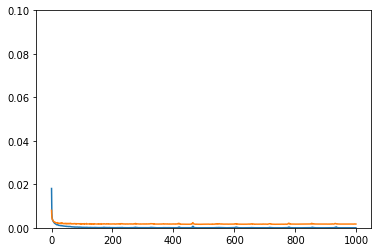

In [6]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.ylim(0,0.1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

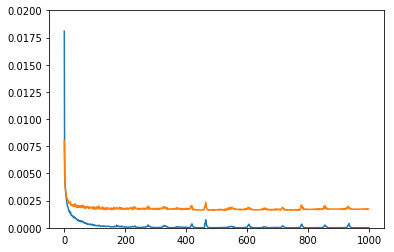

In [8]:
plt.ylim(0,0.02)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

In [1]:
plt.ylim(0,0.7)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

NameError: name 'plt' is not defined

Test 0
True shape: [0.1       0.2       0.3       0.4       0.3       0.2963065]
Predicted shape: [[0.10050246 0.20219666 0.3034655  0.39586806 0.29421815 0.3080424 ]]

Predicted shape: [[0.10551915 0.19910496 0.2899594  0.38978165 0.29513854 0.2948539 ]]



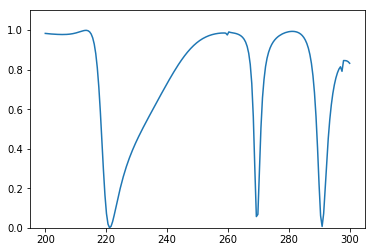

Test 1
True shape: [0.2963065 0.3       0.292613  0.292613  0.3       0.2      ]
Predicted shape: [[0.3532156  0.2668085  0.2998312  0.30658954 0.29134318 0.21957141]]

Predicted shape: [[0.30004728 0.28738284 0.29434264 0.29609427 0.29225132 0.19002648]]



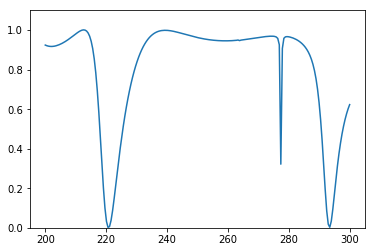

Test 2
True shape: [0.4 0.3 0.3 0.2 0.3 0.2]
Predicted shape: [[0.33268458 0.3076043  0.28161687 0.30569458 0.27599555 0.24246898]]

Predicted shape: [[0.38941672 0.31754208 0.2833698  0.24807543 0.230237   0.2727035 ]]



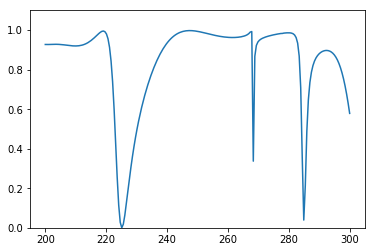

Test 3
True shape: [0.2 0.3 0.4 0.3 0.3 0.3]
Predicted shape: [[0.29498973 0.26884812 0.29370764 0.40733367 0.29617766 0.23452793]]

Predicted shape: [[0.19776493 0.290493   0.4050391  0.3050467  0.30828285 0.30801645]]



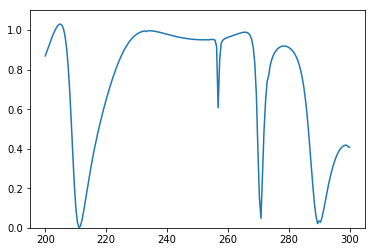

Test 4
True shape: [0.2963065 0.3       0.3       0.2963065 0.3       0.4      ]
Predicted shape: [[0.29446012 0.300246   0.29767177 0.30155092 0.30527955 0.39940313]]

Predicted shape: [[0.30204827 0.30329472 0.29205263 0.293849   0.29719365 0.40948117]]



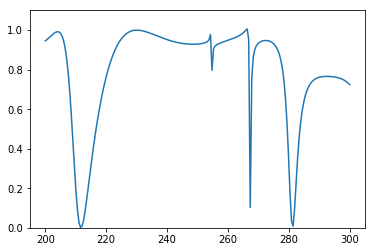

Test 5
True shape: [0.5        0.4        0.4        0.4        0.5        0.49384417]
Predicted shape: [[0.5017806  0.4160889  0.4168191  0.40090954 0.5018349  0.49101102]]

Predicted shape: [[0.48921362 0.39255738 0.4137274  0.38841563 0.49426103 0.49147895]]



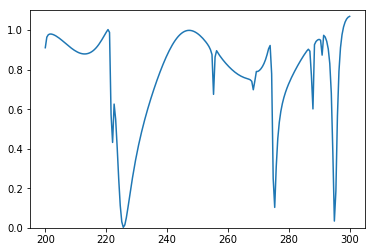

Test 6
True shape: [0.4 0.3 0.4 0.3 0.3 0.4]
Predicted shape: [[0.2976485  0.40864256 0.2981693  0.39508253 0.2966607  0.31326294]]

Predicted shape: [[0.36456585 0.32464677 0.38201058 0.31698602 0.3042602  0.40061367]]



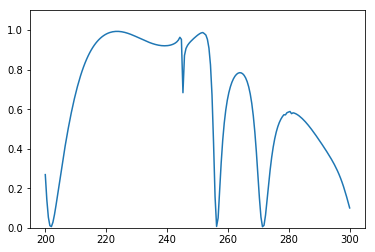

Test 7
True shape: [0.2       0.3       0.4       0.3       0.2963065 0.3      ]
Predicted shape: [[0.28172642 0.26625913 0.28775382 0.40824348 0.2905517  0.26447058]]

Predicted shape: [[0.19390309 0.2875841  0.40348253 0.29863542 0.29722056 0.3165932 ]]



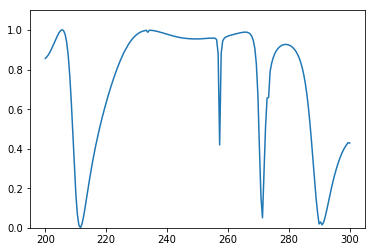

Test 8
True shape: [0.39507534 0.4        0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.36184344 0.41942573 0.41108772 0.45593053 0.41729733 0.4751951 ]]

Predicted shape: [[0.40547144 0.40558597 0.39624974 0.39624295 0.393835   0.50725794]]



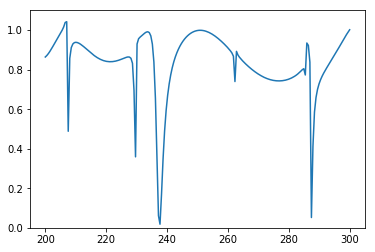

Test 9
True shape: [0.5 0.5 0.4 0.3 0.4 0.3]
Predicted shape: [[0.45589438 0.4841575  0.42225063 0.35220456 0.3986253  0.47008118]]

Predicted shape: [[0.50050855 0.50667995 0.38347936 0.29528743 0.3724902  0.31131124]]



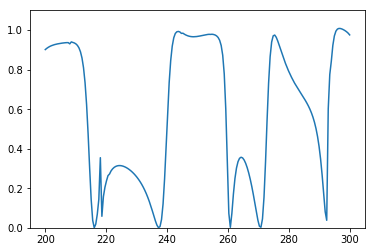

Test 10
True shape: [0.3 0.4 0.5 0.4 0.4 0.3]
Predicted shape: [[0.3590256  0.32685906 0.46476632 0.48702517 0.39751247 0.3574611 ]]

Predicted shape: [[0.29599205 0.39340138 0.503651   0.38981962 0.38744253 0.30852795]]



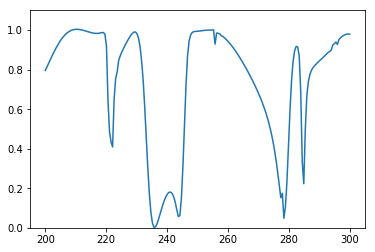

Test 11
True shape: [0.26730196 0.27063391 0.28105791 0.3        0.4        0.3       ]
Predicted shape: [[0.25558233 0.28473762 0.29870448 0.32739043 0.32266915 0.36848328]]

Predicted shape: [[0.2703414  0.27743295 0.28468147 0.30275583 0.4014658  0.30703637]]



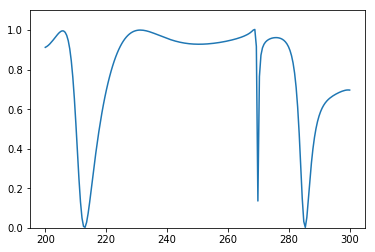

Test 12
True shape: [0.3        0.338636   0.4        0.4        0.5        0.49384417]
Predicted shape: [[0.36277908 0.38323832 0.4178686  0.44216368 0.46044084 0.4295849 ]]

Predicted shape: [[0.28984314 0.34447837 0.40459517 0.3987125  0.49792385 0.4912725 ]]



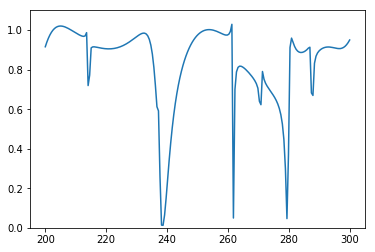

Test 13
True shape: [0.5       0.5       0.4       0.3       0.3       0.2963065]
Predicted shape: [[0.47935683 0.44634318 0.40150476 0.4137662  0.33150727 0.27120662]]

Predicted shape: [[0.4945155  0.48786187 0.39905873 0.30097857 0.31616107 0.2898807 ]]



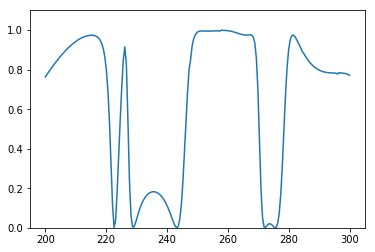

Test 14
True shape: [0.3       0.3       0.4       0.4389726 0.5       0.4      ]
Predicted shape: [[0.32878596 0.32220185 0.4157742  0.44677085 0.427724   0.47555056]]

Predicted shape: [[0.36659008 0.31274092 0.387643   0.39938036 0.49800047 0.40865347]]



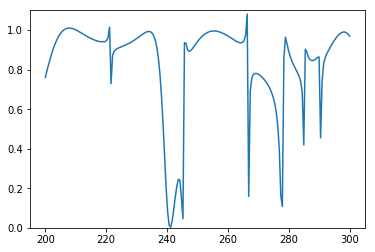

Test 15
True shape: [0.4       0.3       0.2963065 0.3       0.4       0.4      ]
Predicted shape: [[0.35670826 0.28840137 0.3199146  0.31286144 0.37552565 0.4066144 ]]

Predicted shape: [[0.38948834 0.30586702 0.29299203 0.29833084 0.3924361  0.40118825]]



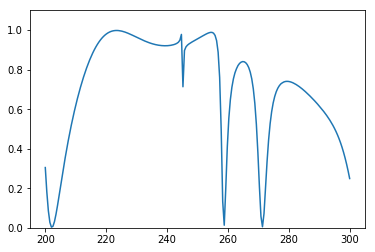

Test 16
True shape: [0.3       0.3       0.2370452 0.2       0.3       0.4      ]
Predicted shape: [[0.29282612 0.28397477 0.20467249 0.24920154 0.3094287  0.33517766]]

Predicted shape: [[0.30297202 0.29641777 0.23744398 0.20088136 0.29941586 0.4027236 ]]



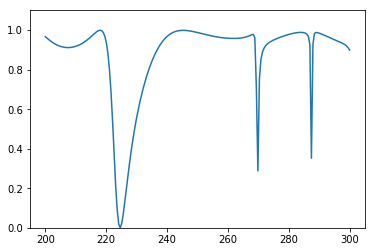

Test 17
True shape: [0.4 0.3 0.3 0.3 0.3 0.3]
Predicted shape: [[0.40066567 0.3028633  0.29876626 0.30518404 0.30234522 0.302113  ]]

Predicted shape: [[0.3951383  0.30254868 0.29427782 0.28887016 0.29930893 0.2984113 ]]



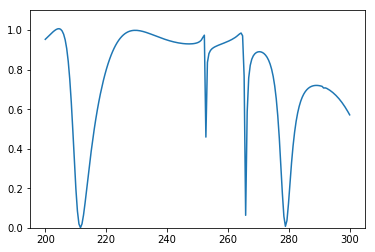

Test 18
True shape: [0.3        0.3        0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.2907796  0.29982364 0.39586207 0.5046492  0.49154744 0.49933386]]

Predicted shape: [[0.30896568 0.3088313  0.40283775 0.4900392  0.500381   0.509606  ]]



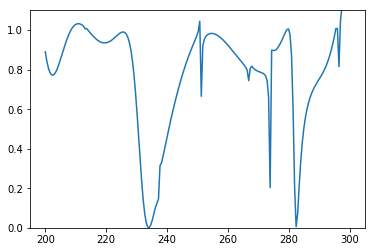

Test 19
True shape: [0.2        0.2        0.2        0.3        0.4        0.39507534]
Predicted shape: [[0.20453468 0.20230111 0.20446876 0.3036855  0.39752042 0.39668247]]

Predicted shape: [[0.19905356 0.20132706 0.2035312  0.2964472  0.40517882 0.39477953]]



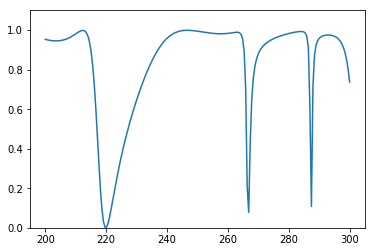

Test 20
True shape: [0.4        0.3        0.3        0.28105791 0.27063391 0.26730196]
Predicted shape: [[0.39437205 0.3041907  0.29754764 0.30313396 0.29869685 0.21115524]]

Predicted shape: [[0.39046073 0.30658478 0.29281086 0.27142352 0.26262236 0.27289286]]



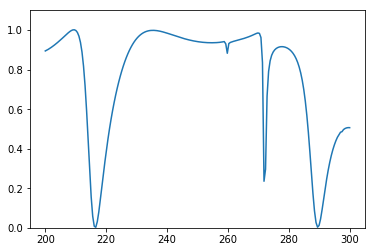

Test 21
True shape: [0.3 0.3 0.3 0.4 0.4 0.3]
Predicted shape: [[0.292319   0.30305195 0.30225602 0.40143585 0.40175372 0.3008992 ]]

Predicted shape: [[0.29671502 0.3045648  0.29226968 0.39026004 0.39853784 0.28848624]]



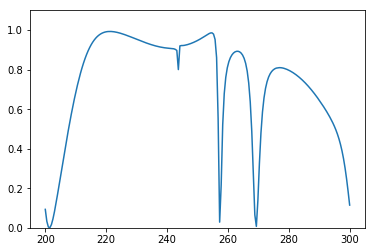

Test 22
True shape: [0.4 0.4 0.4 0.5 0.4 0.4]
Predicted shape: [[0.40626517 0.40055197 0.40467855 0.49582207 0.3964947  0.38768432]]

Predicted shape: [[0.38905957 0.4061902  0.40631473 0.49478695 0.39012405 0.3915881 ]]



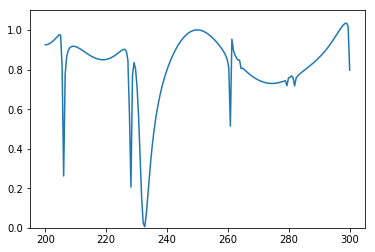

Test 23
True shape: [0.4       0.5       0.4       0.338636  0.3       0.2963065]
Predicted shape: [[0.4839732  0.48432216 0.40062407 0.3275903  0.3342313  0.25532544]]

Predicted shape: [[0.39467925 0.4850046  0.39756343 0.33131123 0.28940398 0.30584177]]



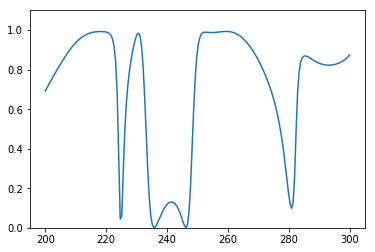

Test 24
True shape: [0.39507534 0.4        0.338636   0.3        0.4        0.5       ]
Predicted shape: [[0.32931072 0.38316548 0.35936552 0.46523383 0.40756178 0.39713705]]

Predicted shape: [[0.38839802 0.40071222 0.34571868 0.2988392  0.41125685 0.49381724]]



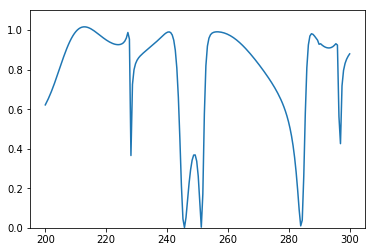

Test 25
True shape: [0.3      0.292613 0.292613 0.3      0.4      0.4     ]
Predicted shape: [[0.29842597 0.29624286 0.29507515 0.30002832 0.3995972  0.39394233]]

Predicted shape: [[0.29587048 0.30231872 0.29139042 0.295752   0.40217763 0.41115403]]



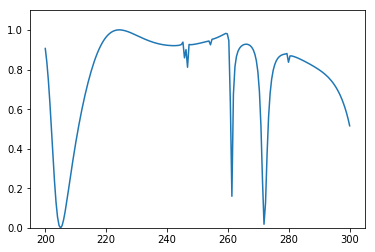

Test 26
True shape: [0.2963065 0.3       0.4       0.3       0.3       0.2963065]
Predicted shape: [[0.30472878 0.30283344 0.3776109  0.30932    0.30366373 0.31396452]]

Predicted shape: [[0.2910553  0.29882574 0.39276105 0.30204868 0.29430568 0.29864314]]



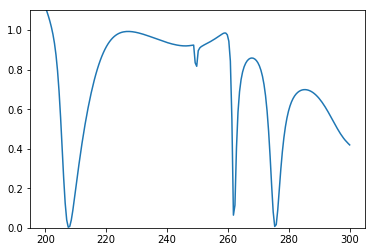

Test 27
True shape: [0.2        0.2370452  0.3        0.31945452 0.35084526 0.4       ]
Predicted shape: [[0.23178694 0.30382925 0.2993672  0.33759564 0.34425926 0.27121407]]

Predicted shape: [[0.20250702 0.23183048 0.2922692  0.31929883 0.33552033 0.39721075]]



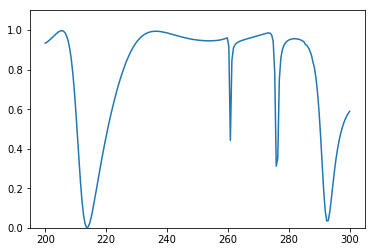

Test 28
True shape: [0.19753767 0.2        0.3        0.4        0.3        0.2       ]
Predicted shape: [[0.21257535 0.22533545 0.27360508 0.3576361  0.32518336 0.22590786]]

Predicted shape: [[0.2045202  0.19581187 0.29809344 0.39965314 0.31158555 0.20099899]]



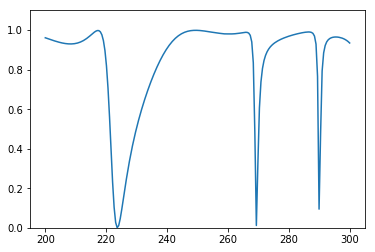

Test 29
True shape: [0.3        0.30864787 0.32607652 0.35485183 0.4        0.3       ]
Predicted shape: [[0.31527734 0.29351115 0.31670755 0.3431153  0.3908679  0.37728617]]

Predicted shape: [[0.30010772 0.31124434 0.31818163 0.3626869  0.39420468 0.28701   ]]



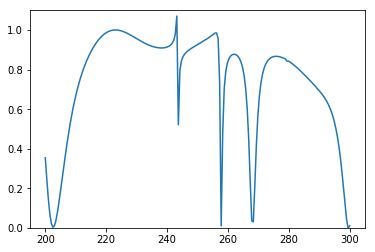

Test 30
True shape: [0.3        0.4        0.4        0.4        0.5        0.49384417]
Predicted shape: [[0.3534059  0.38814002 0.39708555 0.4030984  0.5056036  0.4779315 ]]

Predicted shape: [[0.29556292 0.39969286 0.4044625  0.40122217 0.50158376 0.51193583]]



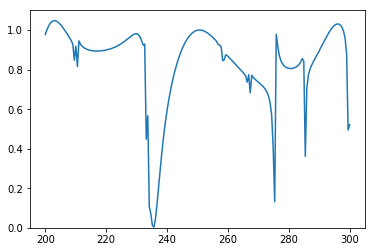

Test 31
True shape: [0.3      0.3      0.338636 0.4      0.4      0.5     ]
Predicted shape: [[0.29984355 0.3188098  0.32534117 0.39431953 0.3840044  0.41820318]]

Predicted shape: [[0.3071691  0.3090168  0.33945873 0.38549164 0.40691674 0.49658206]]



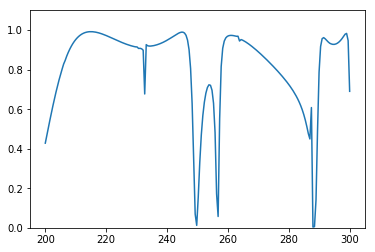

Test 32
True shape: [0.4        0.39507534 0.4        0.4        0.5        0.4       ]
Predicted shape: [[0.37667376 0.3950273  0.38879788 0.39993215 0.4873609  0.40419298]]

Predicted shape: [[0.41243225 0.40077963 0.4099186  0.40475214 0.4919254  0.40190843]]



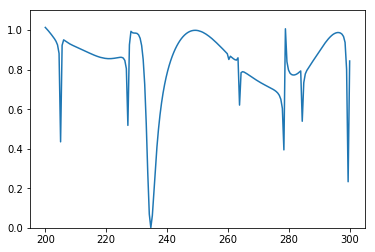

Test 33
True shape: [0.4 0.3 0.2 0.3 0.2 0.2]
Predicted shape: [[0.39522064 0.30667734 0.19435522 0.30180842 0.20424658 0.20283519]]

Predicted shape: [[0.39580086 0.30005187 0.22244444 0.27949557 0.20590878 0.22025624]]



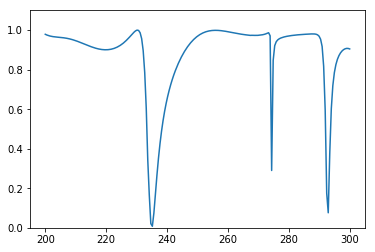

Test 34
True shape: [0.1 0.2 0.2 0.3 0.4 0.4]
Predicted shape: [[0.10217986 0.20469487 0.20430544 0.30567855 0.39836994 0.40502962]]

Predicted shape: [[0.09909853 0.22650644 0.1998716  0.29142132 0.39854315 0.4176749 ]]



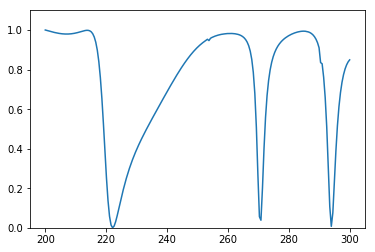

Test 35
True shape: [0.19753767 0.2        0.3        0.3        0.3        0.4       ]
Predicted shape: [[0.22117993 0.21882111 0.30533746 0.29292795 0.28478768 0.41021276]]

Predicted shape: [[0.17482871 0.20083743 0.30275518 0.29375106 0.3129625  0.4134624 ]]



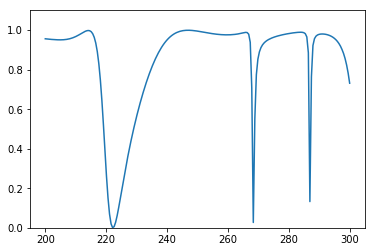

Test 36
True shape: [0.4 0.5 0.4 0.3 0.3 0.3]
Predicted shape: [[0.40009987 0.49929813 0.3968554  0.29822314 0.30118528 0.30007565]]

Predicted shape: [[0.39987823 0.49380025 0.3954147  0.29326516 0.30124617 0.30250463]]



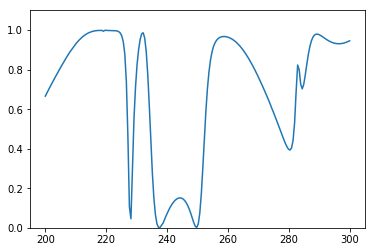

Test 37
True shape: [0.4        0.35084526 0.31945452 0.3        0.2        0.19753767]
Predicted shape: [[0.36790052 0.32026827 0.34081247 0.3043366  0.22629207 0.22172722]]

Predicted shape: [[0.41104966 0.35918307 0.31665754 0.3020847  0.21204293 0.20414053]]



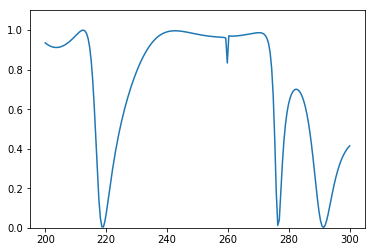

Test 38
True shape: [0.3        0.338636   0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.32727873 0.35909042 0.35949808 0.3941806  0.39603317 0.47887027]]

Predicted shape: [[0.30052376 0.3439387  0.39554968 0.39035618 0.4075404  0.50061834]]



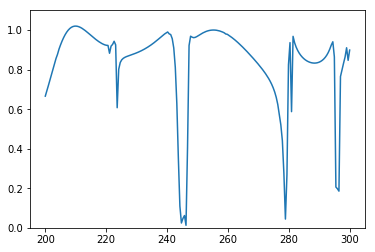

Test 39
True shape: [0.4 0.3 0.3 0.3 0.4 0.5]
Predicted shape: [[0.33922073 0.31720686 0.31454918 0.33511868 0.39641988 0.47671407]]

Predicted shape: [[0.4061296  0.31436175 0.30477458 0.29306507 0.38538453 0.5033145 ]]



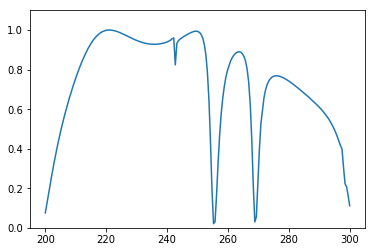

Test 40
True shape: [0.1902113  0.19258231 0.2        0.3        0.4        0.5       ]
Predicted shape: [[0.17965713 0.18124142 0.17341575 0.2994657  0.40211377 0.39991987]]

Predicted shape: [[0.18125126 0.20186114 0.20000044 0.29994756 0.4022999  0.49050692]]



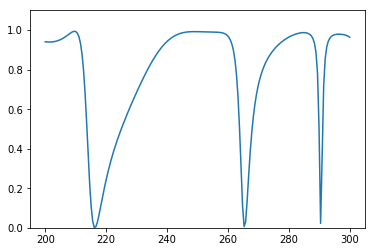

Test 41
True shape: [0.4 0.3 0.2 0.3 0.2 0.3]
Predicted shape: [[0.3329208  0.2683236  0.24894744 0.19568434 0.3175389  0.21268082]]

Predicted shape: [[0.4011536  0.29712933 0.19880807 0.29891214 0.19832489 0.3246797 ]]



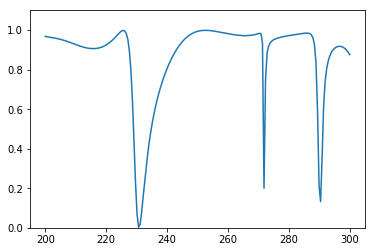

Test 42
True shape: [0.4      0.3      0.292613 0.292613 0.3      0.4     ]
Predicted shape: [[0.40249443 0.30251634 0.3022074  0.2941991  0.30020034 0.3902973 ]]

Predicted shape: [[0.4073454  0.2951734  0.29298824 0.28202376 0.3050814  0.40156922]]



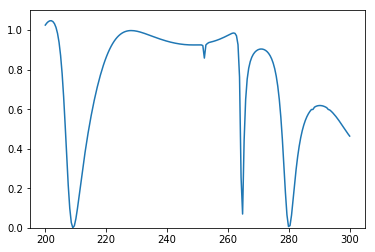

Test 43
True shape: [0.2963065  0.3        0.4        0.3        0.28887347 0.28531695]
Predicted shape: [[0.33247143 0.30338794 0.35935035 0.30083054 0.28577745 0.3160959 ]]

Predicted shape: [[0.2941779  0.29793862 0.38992476 0.29572922 0.29468074 0.2903819 ]]



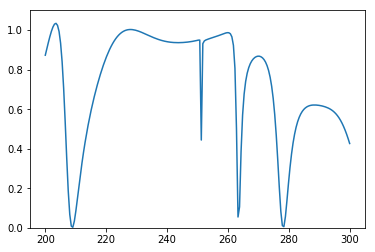

Test 44
True shape: [0.2        0.3        0.338636   0.4        0.4        0.39507534]
Predicted shape: [[0.19519705 0.3049881  0.33693773 0.3983633  0.40326574 0.40979856]]

Predicted shape: [[0.20350888 0.30356696 0.34755844 0.38593704 0.3937563  0.4038078 ]]



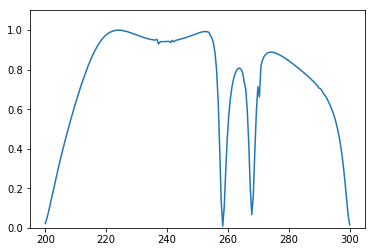

Test 45
True shape: [0.5      0.4      0.338636 0.3      0.4      0.5     ]
Predicted shape: [[0.46866837 0.41802704 0.3235383  0.40602866 0.39037573 0.41250587]]

Predicted shape: [[0.49875444 0.39737275 0.33846605 0.30591217 0.39694667 0.47852662]]



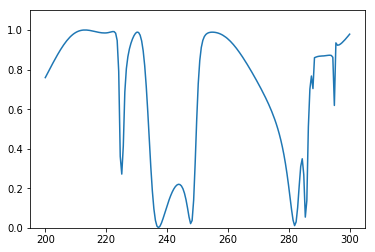

Test 46
True shape: [0.5        0.4        0.4        0.3        0.28887347 0.28531695]
Predicted shape: [[0.50596523 0.40661752 0.3988656  0.3628136  0.3117868  0.23410413]]

Predicted shape: [[0.5147205  0.37820533 0.36534926 0.33381844 0.2891683  0.37099454]]



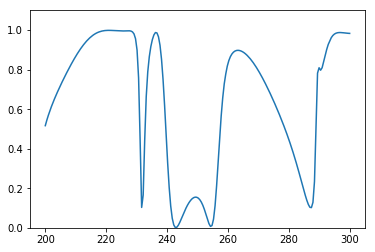

Test 47
True shape: [0.28531695 0.28887347 0.3        0.4        0.338636   0.3       ]
Predicted shape: [[0.29781595 0.30313993 0.28694093 0.34726182 0.36433026 0.35463312]]

Predicted shape: [[0.28681013 0.30850247 0.30095235 0.3844614  0.33987558 0.29762653]]



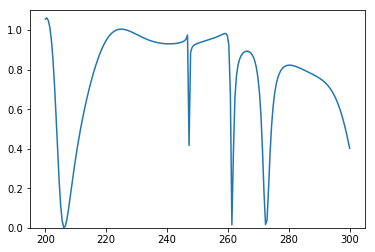

Test 48
True shape: [0.2       0.2       0.2370452 0.3       0.338636  0.4      ]
Predicted shape: [[0.19489145 0.19912651 0.2906186  0.29734477 0.2962654  0.39927325]]

Predicted shape: [[0.19995597 0.2457358  0.28814572 0.28293458 0.33105347 0.3842507 ]]



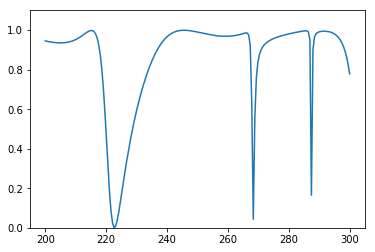

Test 49
True shape: [0.3       0.4       0.4       0.4       0.4389726 0.5      ]
Predicted shape: [[0.33929154 0.3692279  0.41067183 0.43114945 0.4659737  0.39254618]]

Predicted shape: [[0.30043975 0.40146124 0.39055315 0.39251316 0.439046   0.4962046 ]]



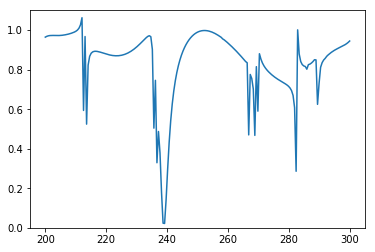

Test 50
True shape: [0.4      0.3      0.3      0.292613 0.292613 0.3     ]
Predicted shape: [[0.37991577 0.30670655 0.2983765  0.293909   0.30006176 0.29863906]]

Predicted shape: [[0.4016268  0.31137955 0.29885024 0.28594357 0.29454768 0.29332113]]



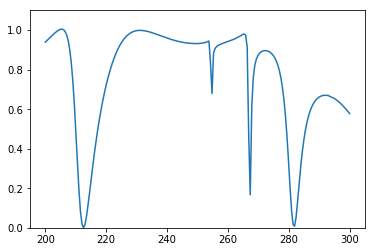

Test 51
True shape: [0.4      0.338636 0.3      0.338636 0.4      0.5     ]
Predicted shape: [[0.3013808  0.38343754 0.30680245 0.3504408  0.3768409  0.45561072]]

Predicted shape: [[0.38268733 0.35171443 0.34759375 0.36613712 0.43819138 0.51275384]]



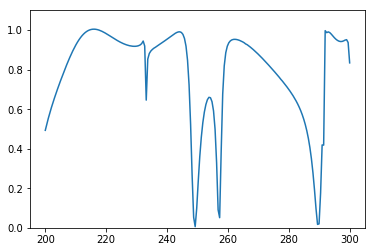

Test 52
True shape: [0.2963065 0.3       0.4       0.4       0.4389726 0.5      ]
Predicted shape: [[0.37869138 0.38059238 0.35384214 0.3821747  0.39307475 0.47753128]]

Predicted shape: [[0.28644767 0.3003124  0.40083194 0.39753902 0.43308067 0.507814  ]]



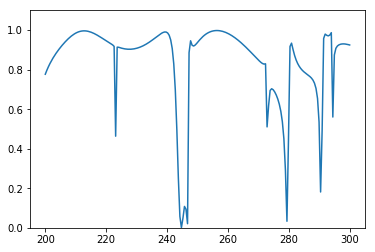

Test 53
True shape: [0.4        0.4        0.39507534 0.4        0.38516462 0.38042261]
Predicted shape: [[0.40309942 0.3944497  0.38347197 0.39375925 0.38384202 0.4026329 ]]

Predicted shape: [[0.3948688  0.39794606 0.4007553  0.39161623 0.39279652 0.3943835 ]]



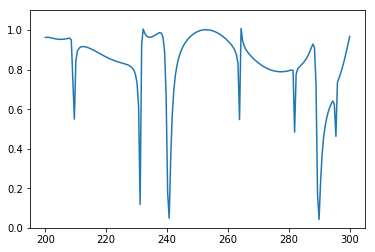

Test 54
True shape: [0.2963065 0.3       0.3       0.2370452 0.2       0.1      ]
Predicted shape: [[0.28013974 0.25297356 0.24719211 0.29122403 0.1763991  0.08399021]]

Predicted shape: [[0.28810412 0.30315012 0.27587605 0.23385331 0.18860896 0.09774813]]



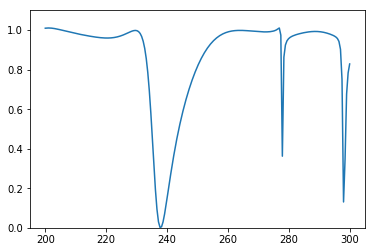

Test 55
True shape: [0.3       0.4       0.3       0.4       0.3       0.2963065]
Predicted shape: [[0.30262646 0.3988552  0.30679053 0.40084988 0.30124456 0.30012038]]

Predicted shape: [[0.31130964 0.36858726 0.3168414  0.40614405 0.28838816 0.30201995]]



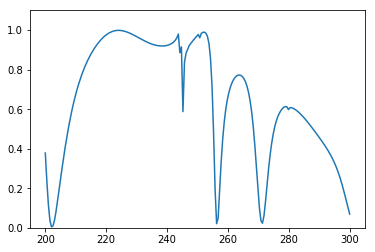

Test 56
True shape: [0.3      0.3      0.3      0.338636 0.4      0.3     ]
Predicted shape: [[0.31446293 0.30124253 0.30621797 0.3022534  0.40599602 0.39135155]]

Predicted shape: [[0.30083477 0.29604286 0.29664084 0.33862418 0.40257767 0.30056375]]



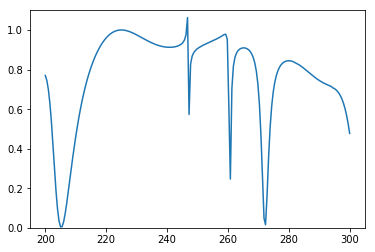

Test 57
True shape: [0.1902113  0.19258231 0.2        0.3        0.338636   0.4       ]
Predicted shape: [[0.21766043 0.21655354 0.27751014 0.3223379  0.3257945  0.3095254 ]]

Predicted shape: [[0.19429412 0.18859643 0.21135497 0.29416752 0.33026922 0.40690142]]



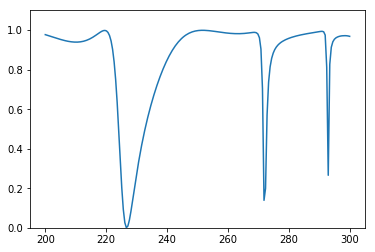

Test 58
True shape: [0.3      0.4      0.3      0.338636 0.4      0.3     ]
Predicted shape: [[0.3995818  0.32029748 0.31176335 0.4093185  0.3100709  0.38880742]]

Predicted shape: [[0.3605523  0.33335412 0.39549994 0.3790754  0.32148764 0.348595  ]]



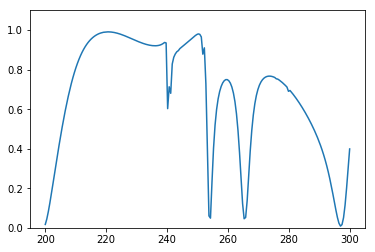

Test 59
True shape: [0.2 0.2 0.3 0.4 0.3 0.3]
Predicted shape: [[0.21776578 0.21191046 0.29823834 0.39536503 0.30112162 0.29930556]]

Predicted shape: [[0.20014352 0.20016968 0.30346158 0.38946664 0.30073056 0.30703485]]



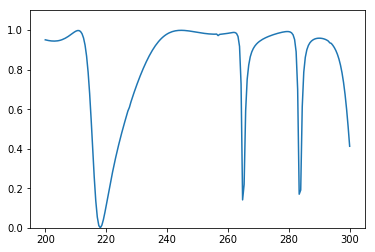

Test 60
True shape: [0.19753767 0.2        0.2        0.3        0.4        0.4       ]
Predicted shape: [[0.19883811 0.1996797  0.20305037 0.30321062 0.4012921  0.39403582]]

Predicted shape: [[0.2022571  0.1959979  0.19806463 0.2935386  0.40165624 0.39303127]]



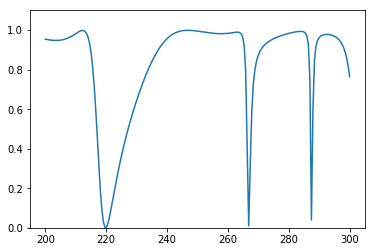

Test 61
True shape: [0.4        0.3        0.2963065  0.3        0.4        0.39507534]
Predicted shape: [[0.40256068 0.30659738 0.2920163  0.29446504 0.39812165 0.39884087]]

Predicted shape: [[0.39461032 0.30686295 0.29407695 0.29957527 0.38765094 0.39480403]]



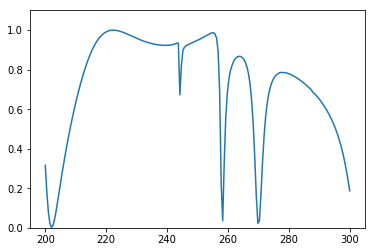

Test 62
True shape: [0.5       0.5       0.4       0.3       0.2370452 0.2      ]
Predicted shape: [[0.47579834 0.41145086 0.37762824 0.35259536 0.29212058 0.23600438]]

Predicted shape: [[0.5041887  0.49892265 0.37849855 0.30069113 0.22887786 0.20216772]]



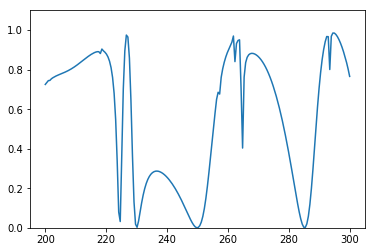

Test 63
True shape: [0.5 0.5 0.4 0.5 0.4 0.4]
Predicted shape: [[0.49513635 0.4974557  0.4082283  0.48427784 0.39686558 0.39744118]]

Predicted shape: [[0.49785405 0.49241218 0.42091534 0.49855953 0.38925338 0.396126  ]]



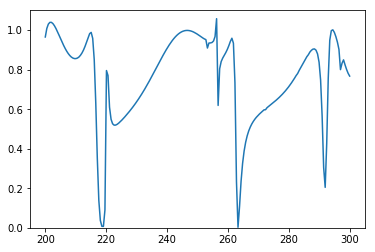

Test 64
True shape: [0.28531695 0.28887347 0.3        0.4        0.3        0.2963065 ]
Predicted shape: [[0.32283014 0.2929663  0.3046263  0.33089304 0.31139627 0.36246952]]

Predicted shape: [[0.28723836 0.28224275 0.29644996 0.3829444  0.3080561  0.30599284]]



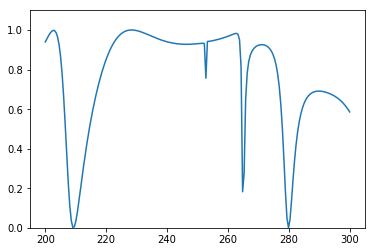

Test 65
True shape: [0.2      0.3      0.338636 0.4      0.4      0.4     ]
Predicted shape: [[0.19993743 0.30254227 0.33552918 0.39969617 0.40194252 0.409792  ]]

Predicted shape: [[0.20756301 0.30653906 0.34826356 0.38956848 0.39389497 0.40548262]]



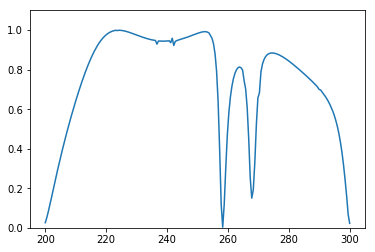

Test 66
True shape: [0.3        0.4        0.39015067 0.39015067 0.4        0.5       ]
Predicted shape: [[0.31720126 0.38905725 0.40650204 0.40002227 0.46005368 0.38357177]]

Predicted shape: [[0.3170612  0.3992342  0.38871175 0.39155704 0.3935785  0.4968688 ]]



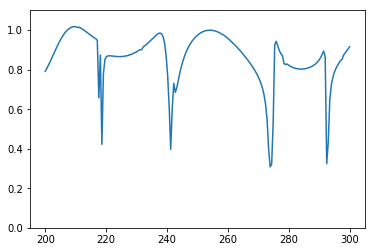

Test 67
True shape: [0.2       0.2370452 0.3       0.4       0.4       0.4      ]
Predicted shape: [[0.21073127 0.24255791 0.29956856 0.39702925 0.39726937 0.39564037]]

Predicted shape: [[0.20597336 0.23427704 0.29656142 0.38046542 0.40858364 0.40835056]]



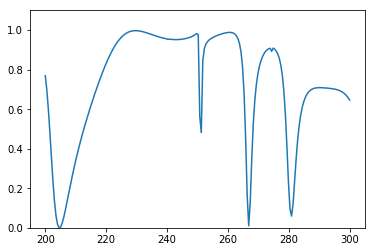

Test 68
True shape: [0.4        0.338636   0.3        0.4        0.39507534 0.4       ]
Predicted shape: [[0.3027204  0.3120628  0.395974   0.40157947 0.39570034 0.39054495]]

Predicted shape: [[0.3893338  0.33306986 0.30713886 0.40467775 0.38686195 0.4076575 ]]



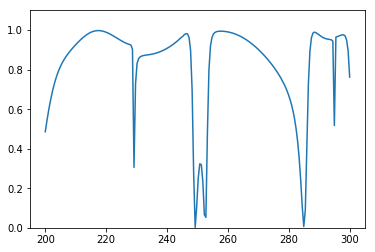

Test 69
True shape: [0.3        0.4        0.39015067 0.39015067 0.4        0.3       ]
Predicted shape: [[0.30910236 0.35659546 0.41060036 0.4084068  0.38380128 0.34406853]]

Predicted shape: [[0.28422984 0.4027223  0.38800603 0.38980126 0.39887005 0.30238703]]



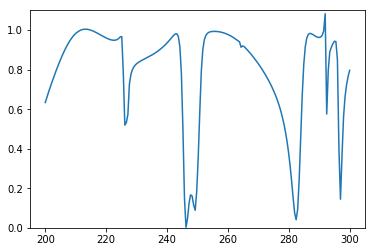

Test 70
True shape: [0.3 0.4 0.4 0.3 0.4 0.5]
Predicted shape: [[0.46798727 0.39129558 0.3063558  0.29604846 0.40826595 0.38812947]]

Predicted shape: [[0.28874862 0.39801663 0.41334683 0.29324377 0.4061159  0.48505932]]



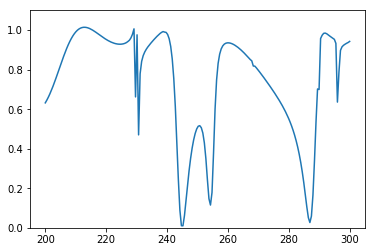

Test 71
True shape: [0.4        0.39507534 0.4        0.5        0.4        0.4       ]
Predicted shape: [[0.39806363 0.3965339  0.39880058 0.50007606 0.4011871  0.39725417]]

Predicted shape: [[0.4099111  0.40299344 0.40213716 0.50918245 0.3697771  0.36079246]]



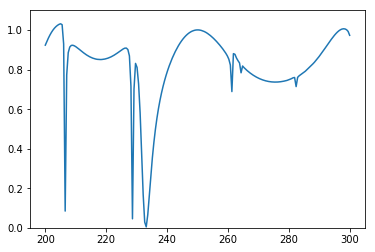

Test 72
True shape: [0.4       0.3       0.4       0.5       0.4389726 0.4      ]
Predicted shape: [[0.31495124 0.35430017 0.41322583 0.5187023  0.43981236 0.43970755]]

Predicted shape: [[0.3964487  0.30714673 0.39719158 0.493843   0.4303471  0.38869932]]



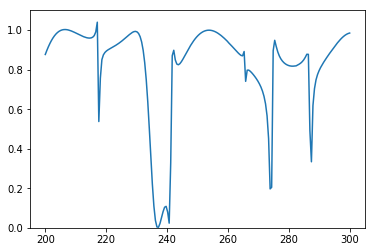

Test 73
True shape: [0.2 0.3 0.4 0.3 0.2 0.3]
Predicted shape: [[0.3030426  0.24836498 0.372526   0.41529053 0.35323113 0.28299305]]

Predicted shape: [[0.19791862 0.29866672 0.41116488 0.2924055  0.19742715 0.30178684]]



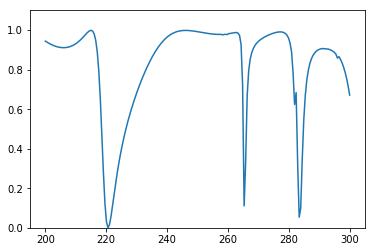

Test 74
True shape: [0.5 0.4 0.3 0.3 0.4 0.4]
Predicted shape: [[0.50816673 0.4028601  0.3147799  0.3032715  0.40661868 0.34974352]]

Predicted shape: [[0.47095054 0.38056073 0.31112897 0.29902452 0.3887346  0.40358004]]



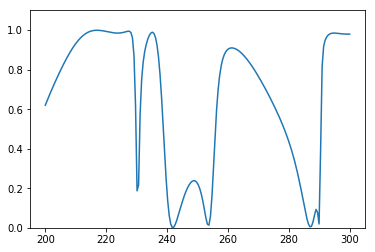

Test 75
True shape: [0.39507534 0.4        0.4        0.4        0.4389726  0.5       ]
Predicted shape: [[0.33168724 0.3430851  0.37025136 0.44002724 0.43911192 0.3737987 ]]

Predicted shape: [[0.4038501  0.39868766 0.41629934 0.39979655 0.42214692 0.49914145]]



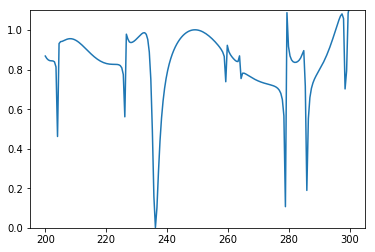

Test 76
True shape: [0.3        0.28887347 0.28531695 0.28887347 0.3        0.4       ]
Predicted shape: [[0.29306608 0.28471845 0.29390383 0.29008225 0.31501976 0.3439759 ]]

Predicted shape: [[0.31595302 0.2863325  0.28428766 0.2764086  0.2999172  0.42970824]]



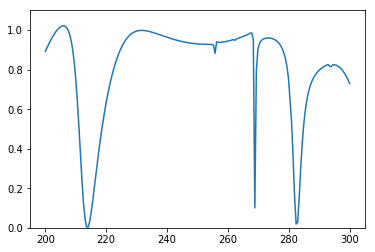

Test 77
True shape: [0.2 0.2 0.2 0.3 0.4 0.4]
Predicted shape: [[0.20730028 0.2023797  0.20320162 0.30396742 0.3940978  0.39881486]]

Predicted shape: [[0.20642748 0.2006298  0.2029356  0.29288182 0.4023571  0.39468935]]



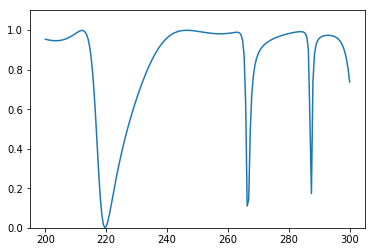

Test 78
True shape: [0.39507534 0.4        0.3        0.3        0.2        0.1       ]
Predicted shape: [[0.40580514 0.4054197  0.31305766 0.3039094  0.20488067 0.10728578]]

Predicted shape: [[0.40049967 0.3829642  0.2997425  0.30135733 0.19903107 0.09454552]]



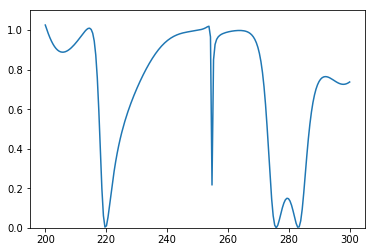

Test 79
True shape: [0.3        0.4        0.5        0.5        0.4        0.39507534]
Predicted shape: [[0.3259263  0.39977252 0.49113503 0.42404804 0.43342564 0.53264976]]

Predicted shape: [[0.27102405 0.3951019  0.5194326  0.4632531  0.44806507 0.4048337 ]]



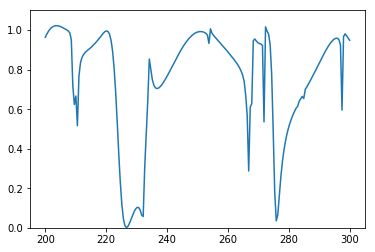

Test 80
True shape: [0.5 0.4 0.4 0.3 0.3 0.4]
Predicted shape: [[0.48487106 0.43346712 0.36676693 0.4023585  0.36090708 0.2605998 ]]

Predicted shape: [[0.5071815  0.40112978 0.3804559  0.30755824 0.29290605 0.40611938]]



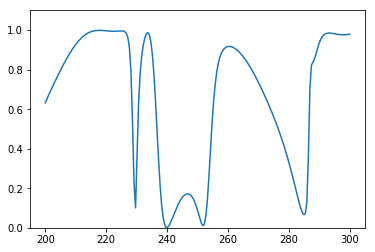

Test 81
True shape: [0.4045085  0.40955075 0.4253254  0.4539905  0.5        0.4       ]
Predicted shape: [[0.40066886 0.37355077 0.36598766 0.37918773 0.4211266  0.37050217]]

Predicted shape: [[0.42292446 0.4028058  0.40650028 0.4574161  0.4642393  0.39111662]]



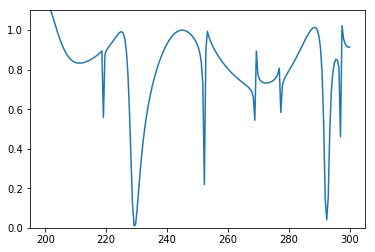

Test 82
True shape: [0.2963065  0.3        0.4        0.39507534 0.4        0.39507534]
Predicted shape: [[0.29941627 0.3018458  0.40217575 0.39427352 0.39655122 0.40291843]]

Predicted shape: [[0.29453695 0.2954356  0.40145105 0.3956356  0.394292   0.41297138]]



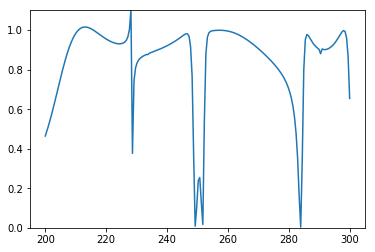

Test 83
True shape: [0.1 0.2 0.3 0.3 0.3 0.4]
Predicted shape: [[0.11038724 0.2121746  0.31010634 0.2959418  0.29497275 0.4138164 ]]

Predicted shape: [[0.1127505  0.20790341 0.282865   0.289809   0.31452388 0.3984258 ]]



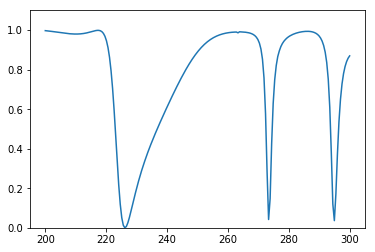

Test 84
True shape: [0.3      0.4      0.338636 0.3      0.2      0.1     ]
Predicted shape: [[0.28497642 0.35255843 0.37721714 0.29876214 0.19056782 0.08822341]]

Predicted shape: [[0.28329992 0.37552372 0.3436458  0.3017478  0.18746711 0.09663963]]



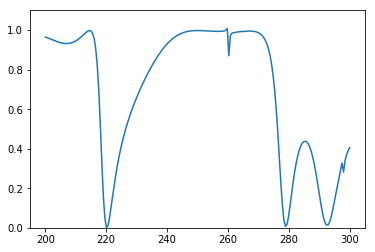

Test 85
True shape: [0.5        0.4        0.4        0.39507534 0.4        0.39507534]
Predicted shape: [[0.49097124 0.3964805  0.38063094 0.40440357 0.39352882 0.41409478]]

Predicted shape: [[0.5007949  0.4206448  0.38716346 0.38886458 0.39283273 0.4005289 ]]



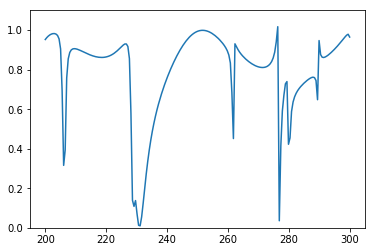

Test 86
True shape: [0.2        0.3        0.3        0.3        0.4        0.39507534]
Predicted shape: [[0.19944593 0.3006106  0.29857403 0.3030373  0.3999267  0.4058651 ]]

Predicted shape: [[0.21159986 0.27215105 0.30473244 0.31171227 0.40565658 0.38927308]]



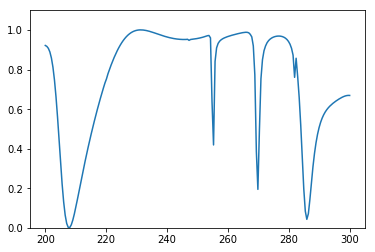

Test 87
True shape: [0.2963065 0.3       0.4       0.3       0.3       0.3      ]
Predicted shape: [[0.30601716 0.30280912 0.37527195 0.31161952 0.30300355 0.31532878]]

Predicted shape: [[0.29534528 0.30032265 0.39153224 0.30405718 0.29506427 0.30325744]]



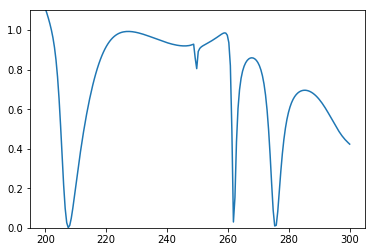

Test 88
True shape: [0.4        0.3        0.2963065  0.3        0.28887347 0.28531695]
Predicted shape: [[0.38401145 0.32018775 0.30399084 0.3030731  0.29878354 0.28282958]]

Predicted shape: [[0.4002702  0.31091392 0.30110505 0.28688464 0.29038692 0.28877378]]



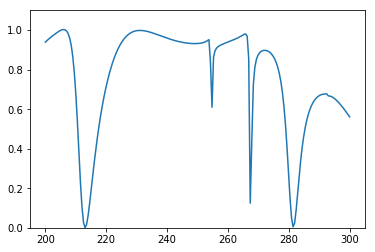

Test 89
True shape: [0.2 0.3 0.2 0.3 0.4 0.3]
Predicted shape: [[0.27014565 0.26151055 0.17697397 0.32018077 0.32656828 0.3551691 ]]

Predicted shape: [[0.2052767  0.30165988 0.19490129 0.29787374 0.41236028 0.3075222 ]]



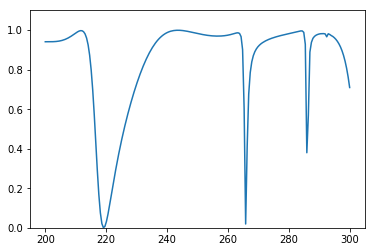

Test 90
True shape: [0.3       0.2963065 0.3       0.4       0.3       0.3      ]
Predicted shape: [[0.31131446 0.30320394 0.29766026 0.37799972 0.30355588 0.34248686]]

Predicted shape: [[0.3039614  0.29135573 0.29875916 0.38457522 0.3110262  0.30684444]]



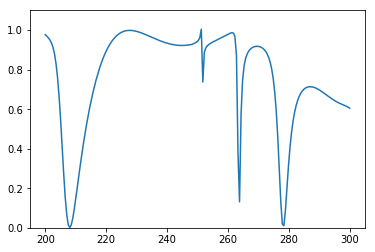

Test 91
True shape: [0.4        0.3        0.31945452 0.35084526 0.4        0.3       ]
Predicted shape: [[0.35468286 0.29899672 0.40448353 0.29740405 0.36706716 0.35431206]]

Predicted shape: [[0.33386707 0.2964176  0.4076945  0.3286265  0.3817972  0.3359994 ]]



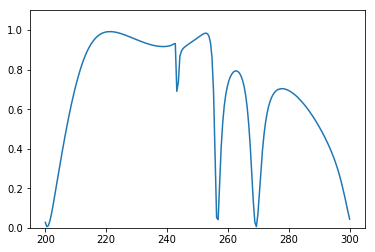

Test 92
True shape: [0.3 0.4 0.4 0.5 0.4 0.5]
Predicted shape: [[0.3267396  0.3770615  0.42447895 0.49189484 0.4365534  0.44150263]]

Predicted shape: [[0.30075586 0.3962294  0.4137482  0.48084798 0.40880513 0.47804824]]



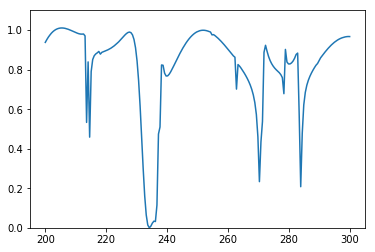

Test 93
True shape: [0.2963065 0.3       0.2963065 0.3       0.4       0.3      ]
Predicted shape: [[0.29987705 0.28737694 0.29774022 0.30792955 0.37675533 0.33190668]]

Predicted shape: [[0.29921207 0.30129695 0.2947101  0.2980107  0.40045246 0.29705635]]



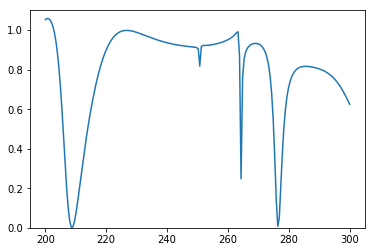

Test 94
True shape: [0.4        0.3        0.4        0.39507534 0.4        0.4       ]
Predicted shape: [[0.4050506  0.30804187 0.3993131  0.39483714 0.40044332 0.3940733 ]]

Predicted shape: [[0.40442556 0.2983235  0.4014226  0.39545995 0.40614146 0.40470648]]



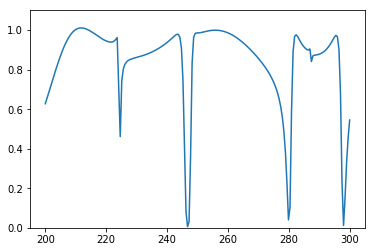

Test 95
True shape: [0.4        0.3        0.4        0.4        0.38516462 0.38042261]
Predicted shape: [[0.33076054 0.32088768 0.39449817 0.383533   0.40301874 0.42920566]]

Predicted shape: [[0.38668942 0.3374083  0.4128569  0.36745626 0.3717593  0.40712598]]



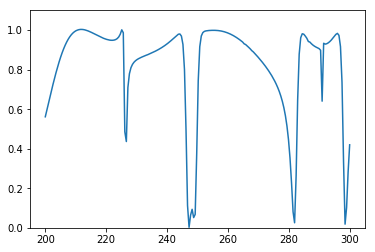

Test 96
True shape: [0.1       0.2       0.2370452 0.3       0.338636  0.4      ]
Predicted shape: [[0.11607495 0.22059104 0.27912968 0.29663706 0.35360053 0.35762087]]

Predicted shape: [[0.12229252 0.17716932 0.24693409 0.31378502 0.35519147 0.39530396]]



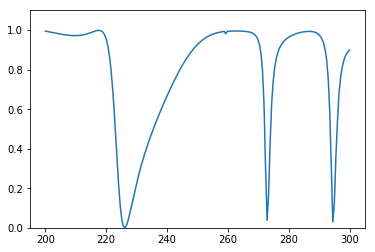

Test 97
True shape: [0.4 0.5 0.4 0.4 0.5 0.5]
Predicted shape: [[0.46847805 0.3952416  0.4186928  0.44646868 0.43416703 0.438706  ]]

Predicted shape: [[0.38787806 0.4829293  0.3942244  0.41071296 0.5077519  0.46936768]]



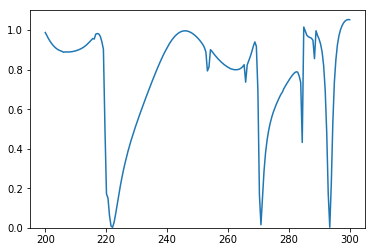

Test 98
True shape: [0.2963065 0.3       0.4       0.5       0.4389726 0.4      ]
Predicted shape: [[0.3011797  0.3055221  0.4015066  0.49302623 0.42735276 0.39305308]]

Predicted shape: [[0.30057764 0.2926981  0.38693297 0.4889356  0.46423265 0.40656167]]



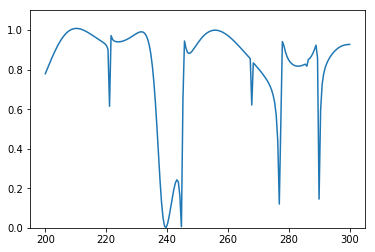

Test 99
True shape: [0.3       0.4       0.5       0.4       0.4389726 0.5      ]
Predicted shape: [[0.3388731  0.35512498 0.40769655 0.49037305 0.45709234 0.50766957]]

Predicted shape: [[0.2920055  0.40120316 0.506253   0.39411077 0.43507698 0.4988817 ]]



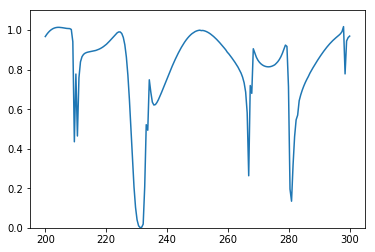

Test 100
True shape: [0.3 0.4 0.4 0.3 0.2 0.1]
Predicted shape: [[0.458321   0.39104822 0.3145219  0.2748401  0.19673508 0.11472162]]

Predicted shape: [[0.38311648 0.41493213 0.29428914 0.30788064 0.1926232  0.10862412]]



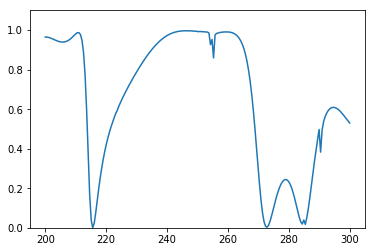

Test 101
True shape: [0.5      0.4      0.4      0.338636 0.3      0.4     ]
Predicted shape: [[0.4318631  0.44912285 0.37423712 0.39781845 0.35415372 0.3570968 ]]

Predicted shape: [[0.5024142  0.40325335 0.39939585 0.3305093  0.28898728 0.40404415]]



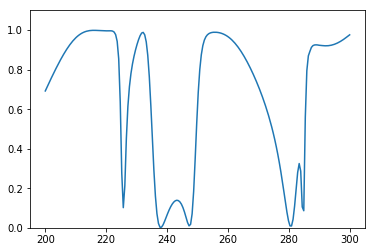

Test 102
True shape: [0.4 0.5 0.4 0.4 0.3 0.3]
Predicted shape: [[0.44423774 0.38152075 0.43373188 0.42334762 0.336959   0.23230202]]

Predicted shape: [[0.38789287 0.493578   0.41725022 0.39771578 0.30934727 0.30016366]]



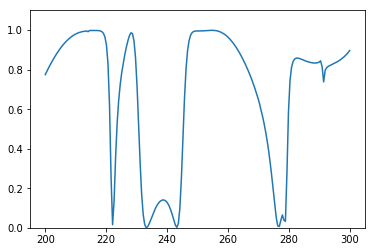

Test 103
True shape: [0.3        0.4        0.41826582 0.44988746 0.5        0.49384417]
Predicted shape: [[0.29996318 0.40537548 0.41580486 0.4657434  0.48189852 0.5033878 ]]

Predicted shape: [[0.30194873 0.4007597  0.42827103 0.44663703 0.49466383 0.5020895 ]]



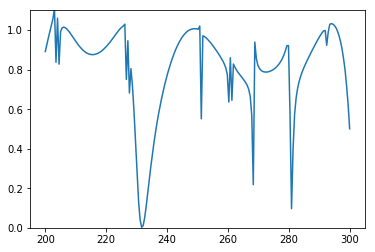

Test 104
True shape: [0.4        0.3        0.2        0.19753767 0.2        0.3       ]
Predicted shape: [[0.39633417 0.31245273 0.20127729 0.207611   0.20696817 0.28351527]]

Predicted shape: [[0.39320052 0.29227698 0.2073218  0.20052618 0.19844678 0.30609027]]



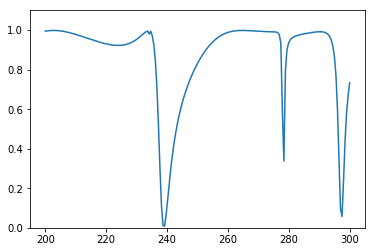

Test 105
True shape: [0.3 0.4 0.4 0.4 0.4 0.5]
Predicted shape: [[0.3283036  0.3882156  0.40265566 0.40341386 0.44574097 0.3826257 ]]

Predicted shape: [[0.30150604 0.39827147 0.4042145  0.3939509  0.41107625 0.49833745]]



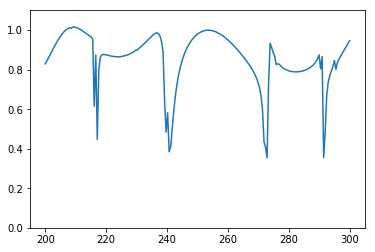

Test 106
True shape: [0.5        0.4        0.39507534 0.4        0.3        0.2       ]
Predicted shape: [[0.5079302  0.40303373 0.39472312 0.37794733 0.297049   0.21636139]]

Predicted shape: [[0.5050644  0.41477653 0.39837527 0.3911993  0.29697034 0.20324568]]



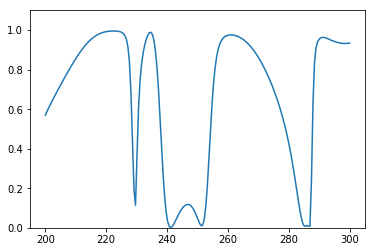

In [11]:
predicted = []
DFNN_all = load_model('DFNN_all')
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    print('Predicted shape: ' + str(DFNN_all.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))
    